# Linear Regression

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.compat.v2.feature_column as fc

import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

## simple, 2-dimensional line of best fit:

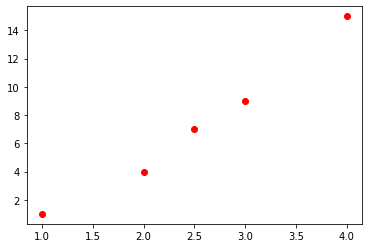

In [7]:
x = [1, 2, 2.5, 3, 4]
y = [1, 4, 7, 9, 15]
plt.plot(x, y, 'ro')
plt.show()

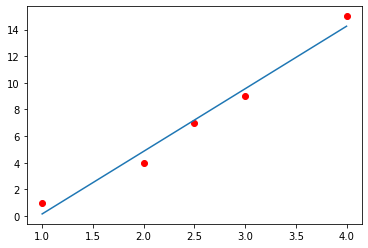

In [9]:
plt.plot(x, y, 'ro')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.show()

## Linear Regression for higher dimensions:

### preparing and perinvestigating the dataset:

In [11]:
# Load datasets
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data

# isolating target variable from dataset
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [20]:
print(dftrain.shape)
print(dfeval.shape)

(627, 9)
(264, 9)


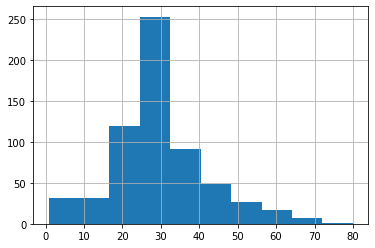

In [21]:
dftrain.age.hist()

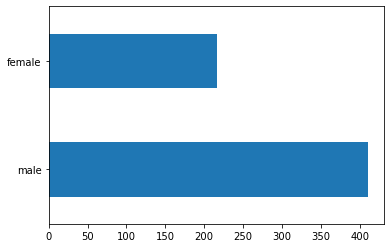

In [22]:
dftrain.sex.value_counts().plot(kind='barh')

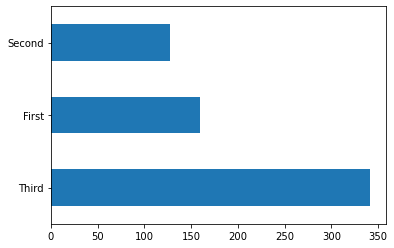

In [23]:
dftrain['class'].value_counts().plot(kind='barh')

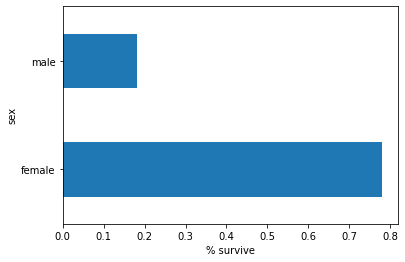

In [32]:
grouped_data = pd.concat([dftrain['sex'], y_train], axis=1).groupby('sex')['survived'].mean().plot(kind='barh').set_xlabel('% survive')

### training a linear model requires numeric data. so we do the following:

In [35]:
CATEGORIAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORIAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique() # gets a list of all unique values from a given feature column
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='fare', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


### The Training Process:

In [43]:
# creating an Input Function
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

# creating an estimator object
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

# training the model
linear_est.train(train_input_fn)

# evaluating the model
result = linear_est.evaluate(eval_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Lukas\\AppData\\Local\\Temp\\tmpaz1xyex5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, y

In [45]:
print(result)

{'accuracy': 0.75, 'accuracy_baseline': 0.625, 'auc': 0.83226204, 'auc_precision_recall': 0.78267944, 'average_loss': 0.48873767, 'label/mean': 0.375, 'loss': 0.4845742, 'precision': 0.6460177, 'prediction/mean': 0.42480844, 'recall': 0.7373737, 'global_step': 200}


### Making predictions:

In [72]:
prediction = list(linear_est.predict(eval_input_fn))
print("training_data:\n" + str(dfeval.loc[2]))
print("predicted value: " + str(prediction[2]['probabilities'][1]))
print("actual value: " + str(y_eval[2]))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Lukas\AppData\Local\Temp\tmpaz1xyex5\model.ckpt-34000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
training_data:
sex                        female
age                            58
n_siblings_spouses              0
parch                           0
fare                        26.55
class                    

### Experimenting with model parameters:

In [61]:
results = {}
for num_epochs in range(10, 101, 10):
    train_input_fn = make_input_fn(dftrain, y_train, num_epochs=num_epochs)
    linear_est.train(train_input_fn)
    result = linear_est.evaluate(eval_input_fn)
    clear_output()
    for key in result.keys():
        try:
            results[key].append(result[key])
        except KeyError:
            results[key] = [result[key]]

In [62]:
print(results)

{'accuracy': [0.78409094, 0.7765151, 0.78409094, 0.7916667, 0.7878788, 0.78409094, 0.780303, 0.78409094, 0.780303, 0.78409094], 'accuracy_baseline': [0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625], 'auc': [0.8408938, 0.8391797, 0.8410775, 0.8371595, 0.83832264, 0.8410774, 0.84086317, 0.839547, 0.8404959, 0.8397307], 'auc_precision_recall': [0.7792137, 0.7819987, 0.7793079, 0.7741466, 0.7742288, 0.77745175, 0.77727395, 0.77551615, 0.77783835, 0.7758501], 'average_loss': [0.47199517, 0.47592017, 0.47284403, 0.46721983, 0.4670309, 0.46832025, 0.46892715, 0.46721232, 0.46876407, 0.46714154], 'label/mean': [0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375], 'loss': [0.45438072, 0.45780146, 0.4550413, 0.45118392, 0.45092863, 0.45154318, 0.45203066, 0.4507951, 0.45179546, 0.45065922], 'precision': [0.7019231, 0.6886792, 0.7019231, 0.72, 0.7128713, 0.7058824, 0.69902915, 0.7058824, 0.69902915, 0.7058824], 'prediction/mean': [0.40990806, 0.4207733, 0.4

In [64]:
results_df = pd.DataFrame.from_dict(results)
results_df.describe()

,accuracy,accuracy_baseline,auc,auc_precision_recall,average_loss,label/mean,loss,precision,prediction/mean,recall,global_step
count,10.000000,10.000,10.000000,10.000000,10.000000,10.000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.783712,0.625,0.839835,0.777283,0.469538,0.375,0.452616,0.704110,0.397036,0.730303,27400.000000
std,0.004169,0.000,0.001320,0.002466,0.003036,0.000,0.002359,0.008419,0.013470,0.004879,3713.040084
min,0.776515,0.625,0.837160,0.774147,0.467031,0.375,0.450659,0.688679,0.380455,0.727273,23200.000000
25%,0.781250,0.625,0.839272,0.775600,0.467214,0.375,0.450992,0.699753,0.386941,0.727273,24400.000000
50%,0.784091,0.625,0.840113,0.777363,0.468542,0.375,0.451669,0.703903,0.396616,0.727273,26600.000000
75%,0.784091,0.625,0.840886,0.778870,0.471228,0.375,0.453793,0.705882,0.406917,0.734848,29800.000000
max,0.791667,0.625,0.841078,0.781999,0.475920,0.375,0.457801,0.720000,0.420773,0.737374,34000.000000


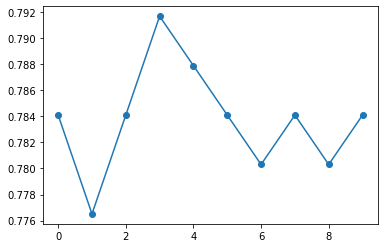

In [67]:
results_df['accuracy'].plot(style='-o')